In [1]:
import os
os.chdir("../../")
import pandas as pd
import matplotlib.pyplot as plt

from src.google_trends import GT
from dotenv import load_dotenv
load_dotenv()

from bokeh.plotting import figure, show, output_notebook, output_file
from bokeh.models import CustomJS, Select, ColumnDataSource, HoverTool, BoxZoomTool, ResetTool, Legend, WheelZoomTool
from bokeh.palettes import Category20
output_notebook()

import warnings
warnings.filterwarnings("ignore")

Loading BokehJS ...

In [2]:
saved_path = os.getcwd() + "/outputs/text/solomon_islands/trends/"
if not os.path.exists(saved_path):
    os.mkdir(saved_path)

In [3]:
GoogleAPIkey = os.getenv("GoogleAPIkey")

In [4]:
gt = GT(GoogleAPIkey)

benchmark_term = "government"
geo_iso2 = "PG"
start_time = "2016-01"

inflation_words = [
    "inflation", "inflation rate", "CPI", "prices", "food price",
    "price index", "price in port moresby", "port moresby price",
    "price in lae", "lae price"
]

job_words = [
    "job",
    "unemployment",
    "hiring",
    "layoff",
    "job market",
    "job opportunities",
    "job vacancy",
    "job vacancies",
    "unemployment rate",
    "jobs in port moresby",
    "job in port moresby",
    "job in lae",
    "jobs in lae",
]

benchmark_df = gt.to_df(gt.get_graph(benchmark_term, geo_iso2, start_time))
benchmark_df = benchmark_df.drop("term", axis=1).rename({"value": "benchmark"},
                                                        axis=1)

local_trends_df = pd.DataFrame()
for term in job_words:
    r = gt.get_graph(term, geo_iso2, start_time)
    r_df = gt.to_df(r)
    print(
        f"{term} : {(r_df.value==0).sum()} out of {len(r_df)} rows with zero values."
    )
    r_df = (r_df.drop("term", axis=1).rename({"value": term}, axis=1))

    if local_trends_df.empty:
        local_trends_df = r_df
    else:
        local_trends_df = local_trends_df.merge(r_df, how="left", on="date")

local_trends_df.columns = [
    col.lower().replace(" ", "_") for col in local_trends_df.columns
]

job : 0 out of 94 rows with zero values.
unemployment : 18 out of 94 rows with zero values.
hiring : 32 out of 94 rows with zero values.
layoff : 72 out of 94 rows with zero values.
job market : 70 out of 94 rows with zero values.
job opportunities : 23 out of 94 rows with zero values.
job vacancy : 2 out of 94 rows with zero values.
job vacancies : 0 out of 94 rows with zero values.
unemployment rate : 54 out of 94 rows with zero values.
jobs in port moresby : 21 out of 94 rows with zero values.
job in port moresby : 25 out of 94 rows with zero values.
job in lae : 32 out of 94 rows with zero values.
jobs in lae : 52 out of 94 rows with zero values.


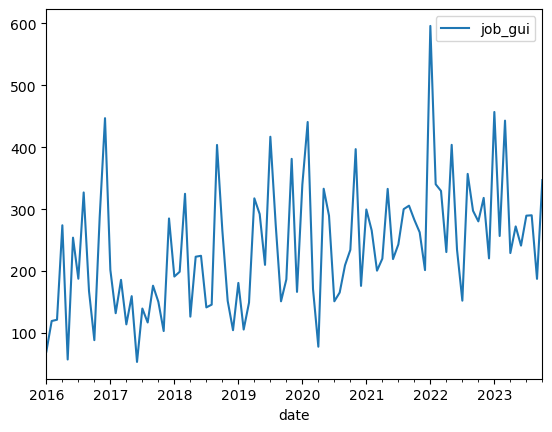

In [6]:
df = local_trends_df.merge(benchmark_df).drop("date", axis=1).fillna(0)

# Benchmark keyword volumes
svi_bt = df["benchmark"] / df["benchmark"].max()
svi_bj = df["benchmark"] / df.max(axis=1)

df["weight"] = (svi_bt / svi_bj).fillna(0)
for i in df.index:
    df.iloc[i, :-4] = df.iloc[i, :-4] * df["weight"][i]
    
df["job_gui"] =  df.iloc[:, :-4].sum(axis=1)

df["date"] = r_df["date"].tolist()
gui = df.set_index("date").groupby(pd.Grouper(freq='MS'))[["job_gui"]].sum().reset_index()
gui.plot(x="date");

In [7]:
# output_file(filename=saved_path + "solomon_islands_local_trends.html",
#             title="Solomon Islands Google Trends")

# hover = HoverTool(tooltips=[('Date', '@date{%Y-%m-%d}'), ('Number', '@$name')],
#                   formatters={'@date': 'datetime'})
# p = figure(
#     height=400,
#     width=700,
#     title="Google Trend Index By Month (search conducted in Solomon Islands)",
#     x_axis_type="datetime",
#     x_axis_label="Date",
#     y_axis_label="Google Trend Index",
#     tools=[hover, BoxZoomTool(),
#            ResetTool(), WheelZoomTool()])

# cols = [col for col in local_trends_df.columns if col != "date"]
# p.add_layout(Legend(), 'right')
# source = ColumnDataSource(trends_df)

# for col, color in zip(cols, Category20[3]):
#     # have to use different colnames for y-coords so tooltip can refer to @$name
#     p.line('date',
#            col,
#            source=local_trends_df,
#            name=col,
#            legend_label=col,
#            color=color)

# p.legend.label_text_font_size = '9pt'
# p.legend.click_policy = "mute"
# p.legend.location = "top_left"

# show(p)